## Net Surgery for a Fully-Convolutional Model

Caffe models can be transformed to your particular needs by editing the network parameters. In this example, we take the standard Caffe Reference ImageNet model "CaffeNet" and transform it into a fully-convolutional model for efficient, dense inference on large inputs. This model generates a classification map that covers a given input size instead of a single classification. In particular a 8 $\times$ 8 classification map on a 451 $\times$ 451 input gives 64x the output in only 3x the time. The computation exploits a natural efficiency of convolutional neural network (CNN) structure by dynamic programming in the forward pass from shallow to deep layers.

To do so we translate the inner product classifier layers of CaffeNet into convolutional layers. This is the only change: the other layer types are agnostic to spatial size. Convolution is translation-invariant, activations are elementwise operations, and so on. The `fc6` inner product when carried out as convolution by `fc6-conv` turns into a 6 \times 6 filter with stride 1 on `pool5`. Back in image space this gives a classification for each 227 $\times$ 227 box with stride 32 in pixels. Remember the equation for output map / receptive field size, output = (input - kernel_size) / stride + 1, and work out the indexing details for a clear understanding.

Roll up your sleeves for net surgery with pycaffe!

In [1]:
!diff imagenet/bvlc_caffenet_full_conv.prototxt ../models/bvlc_reference_caffenet/deploy.prototxt

1,2c1
< # This file is for the net_surgery.ipynb example notebook.
< name: "CaffeNetConv"
---
> name: "CaffeNet"
4c3
< input_dim: 1
---
> input_dim: 10
6,7c5,6
< input_dim: 451
< input_dim: 451
---
> input_dim: 227
> input_dim: 227
152,153c151,152
<   name: "fc6-conv"
<   type: CONVOLUTION
---
>   name: "fc6"
>   type: INNER_PRODUCT
155,156c154,155
<   top: "fc6-conv"
<   convolution_param {
---
>   top: "fc6"
>   inner_product_param {
158d156
<     kernel_size: 6
164,165c162,163
<   bottom: "fc6-conv"
<   top: "fc6-conv"
---
>   bottom: "fc6"
>   top: "fc6"
170,171c168,169
<   bottom: "fc6-conv"
<   top: "fc6-conv"
---
>   bottom: "fc6"
>   top: "fc6"
177,181c175,179
<   name: "fc7-conv"
<   type: CONVOLUTION
<   bottom: "fc6-conv"
<   top: "fc7-conv"
<   convolution_param {
---
>   name: "fc7"
>   type: INNER_PRODUCT
>   bottom: "fc6"
>   top: "fc7"
>   inner_product_param {
183d180
<     kernel_size: 1
189,190c186,187
<   bottom: "fc7-conv"
<   top: "fc7-conv"
---
>   bottom: "fc7"


The only differences needed in the architecture are to change the fully-connected classifier inner product layers into convolutional layers with the right filter size -- 6 x 6, since the reference model classifiers take the 36 elements of `pool5` as input -- and stride 1 for dense classification. Note that the layers are renamed so that Caffe does not try to blindly load the old parameters when it maps layer names to the pretrained model.

I0320 19:37:29.139435 2113708800 net.cpp:336] Input 0 -> data
I0320 19:37:29.139477 2113708800 layer_factory.hpp:74] Creating layer conv1
I0320 19:37:29.139489 2113708800 net.cpp:76] Creating Layer conv1
I0320 19:37:29.139497 2113708800 net.cpp:372] conv1 <- data
I0320 19:37:29.139508 2113708800 net.cpp:334] conv1 -> conv1
I0320 19:37:29.139518 2113708800 net.cpp:105] Setting up conv1
I0320 19:37:29.139564 2113708800 net.cpp:112] Top shape: 10 96 55 55 (2904000)
I0320 19:37:29.139580 2113708800 layer_factory.hpp:74] Creating layer relu1
I0320 19:37:29.139595 2113708800 net.cpp:76] Creating Layer relu1
I0320 19:37:29.139602 2113708800 net.cpp:372] relu1 <- conv1
I0320 19:37:29.139611 2113708800 net.cpp:323] relu1 -> conv1 (in-place)
I0320 19:37:29.139621 2113708800 net.cpp:105] Setting up relu1
I0320 19:37:29.139628 2113708800 net.cpp:112] Top shape: 10 96 55 55 (2904000)
I0320 19:37:29.139636 2113708800 layer_factory.hpp:74] Creating layer pool1
I0320 19:37:29.139646 2113708800 net.cpp:76] Creating Layer pool1
I0320 19:37:29.139652 2113708800 net.cpp:372] pool1 <- conv1
I0320 19:37:29.139660 2113708800 net.cpp:334] pool1 -> pool1
I0320 19:37:29.139672 2113708800 net.cpp:105] Setting up pool1
I0320 19:37:29.139680 2113708800 net.cpp:112] Top shape: 10 96 27 27 (699840)
I0320 19:37:29.139688 2113708800 layer_factory.hpp:74] Creating layer norm1
I0320 19:37:29.139698 2113708800 net.cpp:76] Creating Layer norm1
I0320 19:37:29.139705 2113708800 net.cpp:372] norm1 <- pool1
I0320 19:37:29.139714 2113708800 net.cpp:334] norm1 -> norm1
I0320 19:37:29.139724 2113708800 net.cpp:105] Setting up norm1
I0320 19:37:29.139731 2113708800 net.cpp:112] Top shape: 10 96 27 27 (699840)
I0320 19:37:29.139739 2113708800 layer_factory.hpp:74] Creating layer conv2
I0320 19:37:29.139750 2113708800 net.cpp:76] Creating Layer conv2
I0320 19:37:29.139755 2113708800 net.cpp:372] conv2 <- norm1
I0320 19:37:29.139765 2113708800 net.cpp:334] conv2 -> conv2
I0320 19:37:29.139773 2113708800 net.cpp:105] Setting up conv2
I0320 19:37:29.140208 2113708800 net.cpp:112] Top shape: 10 256 27 27 (1866240)
I0320 19:37:29.140224 2113708800 layer_factory.hpp:74] Creating layer relu2
I0320 19:37:29.140234 2113708800 net.cpp:76] Creating Layer relu2
I0320 19:37:29.140241 2113708800 net.cpp:372] relu2 <- conv2
I0320 19:37:29.140254 2113708800 net.cpp:323] relu2 -> conv2 (in-place)
I0320 19:37:29.140261 2113708800 net.cpp:105] Setting up relu2
I0320 19:37:29.140269 2113708800 net.cpp:112] Top shape: 10 256 27 27 (1866240)
I0320 19:37:29.140275 2113708800 layer_factory.hpp:74] Creating layer pool2
I0320 19:37:29.140283 2113708800 net.cpp:76] Creating Layer pool2
I0320 19:37:29.140290 2113708800 net.cpp:372] pool2 <- conv2
I0320 19:37:29.140298 2113708800 net.cpp:334] pool2 -> pool2
I0320 19:37:29.140306 2113708800 net.cpp:105] Setting up pool2
I0320 19:37:29.140314 2113708800 net.cpp:112] Top shape: 10 256 13 13 (432640)
I0320 19:37:29.140322 2113708800 layer_factory.hpp:74] Creating layer norm2
I0320 19:37:29.140331 2113708800 net.cpp:76] Creating Layer norm2
I0320 19:37:29.140336 2113708800 net.cpp:372] norm2 <- pool2
I0320 19:37:29.140344 2113708800 net.cpp:334] norm2 -> norm2
I0320 19:37:29.140352 2113708800 net.cpp:105] Setting up norm2
I0320 19:37:29.140360 2113708800 net.cpp:112] Top shape: 10 256 13 13 (432640)
I0320 19:37:29.140368 2113708800 layer_factory.hpp:74] Creating layer conv3
I0320 19:37:29.140377 2113708800 net.cpp:76] Creating Layer conv3
I0320 19:37:29.140383 2113708800 net.cpp:372] conv3 <- norm2
I0320 19:37:29.140391 2113708800 net.cpp:334] conv3 -> conv3
I0320 19:37:29.140399 2113708800 net.cpp:105] Setting up conv3
I0320 19:37:29.141602 2113708800 net.cpp:112] Top shape: 10 384 13 13 (648960)
I0320 19:37:29.141623 2113708800 layer_factory.hpp:74] Creating layer relu3
I0320 19:37:29.141633 2113708800 net.cpp:76] Creating Layer relu3
I0320 19:37:29.141639 2113708800 net.cpp:372] relu3 <- conv3
I0320 19:37:29.141654 2113708800 net.cpp:323] relu3 -> conv3 (in-place)
I0320 19:37:29.141664 2113708800 net.cpp:105] Setting up relu3
I0320 19:37:29.141670 2113708800 net.cpp:112] Top shape: 10 384 13 13 (648960)
I0320 19:37:29.141677 2113708800 layer_factory.hpp:74] Creating layer conv4
I0320 19:37:29.141686 2113708800 net.cpp:76] Creating Layer conv4
I0320 19:37:29.141693 2113708800 net.cpp:372] conv4 <- conv3
I0320 19:37:29.141700 2113708800 net.cpp:334] conv4 -> conv4
I0320 19:37:29.141710 2113708800 net.cpp:105] Setting up conv4
I0320 19:37:29.142592 2113708800 net.cpp:112] Top shape: 10 384 13 13 (648960)
I0320 19:37:29.142611 2113708800 layer_factory.hpp:74] Creating layer relu4
I0320 19:37:29.142621 2113708800 net.cpp:76] Creating Layer relu4
I0320 19:37:29.142628 2113708800 net.cpp:372] relu4 <- conv4
I0320 19:37:29.142638 2113708800 net.cpp:323] relu4 -> conv4 (in-place)
I0320 19:37:29.142647 2113708800 net.cpp:105] Setting up relu4
I0320 19:37:29.142653 2113708800 net.cpp:112] Top shape: 10 384 13 13 (648960)
I0320 19:37:29.142663 2113708800 layer_factory.hpp:74] Creating layer conv5
I0320 19:37:29.142673 2113708800 net.cpp:76] Creating Layer conv5
I0320 19:37:29.142678 2113708800 net.cpp:372] conv5 <- conv4
I0320 19:37:29.142688 2113708800 net.cpp:334] conv5 -> conv5
I0320 19:37:29.142698 2113708800 net.cpp:105] Setting up conv5
I0320 19:37:29.142989 2113708800 net.cpp:112] Top shape: 10 256 13 13 (432640)
I0320 19:37:29.143004 2113708800 layer_factory.hpp:74] Creating layer relu5
I0320 19:37:29.143013 2113708800 net.cpp:76] Creating Layer relu5
I0320 19:37:29.143018 2113708800 net.cpp:372] relu5 <- conv5
I0320 19:37:29.143026 2113708800 net.cpp:323] relu5 -> conv5 (in-place)
I0320 19:37:29.143038 2113708800 net.cpp:105] Setting up relu5
I0320 19:37:29.143043 2113708800 net.cpp:112] Top shape: 10 256 13 13 (432640)
I0320 19:37:29.143049 2113708800 layer_factory.hpp:74] Creating layer pool5
I0320 19:37:29.143057 2113708800 net.cpp:76] Creating Layer pool5
I0320 19:37:29.143062 2113708800 net.cpp:372] pool5 <- conv5
I0320 19:37:29.143071 2113708800 net.cpp:334] pool5 -> pool5
I0320 19:37:29.143079 2113708800 net.cpp:105] Setting up pool5
I0320 19:37:29.143086 2113708800 net.cpp:112] Top shape: 10 256 6 6 (92160)  // __Note here__
I0320 19:37:29.143093 2113708800 layer_factory.hpp:74] Creating layer fc6
I0320 19:37:29.143103 2113708800 net.cpp:76] Creating Layer fc6
I0320 19:37:29.143108 2113708800 net.cpp:372] fc6 <- pool5
I0320 19:37:29.143116 2113708800 net.cpp:334] fc6 -> fc6
I0320 19:37:29.143124 2113708800 net.cpp:105] Setting up fc6
I0320 19:37:29.231870 2113708800 net.cpp:112] Top shape: 10 4096 1 1 (40960)
I0320 19:37:29.231916 2113708800 layer_factory.hpp:74] Creating layer relu6
I0320 19:37:29.231937 2113708800 net.cpp:76] Creating Layer relu6
I0320 19:37:29.231943 2113708800 net.cpp:372] relu6 <- fc6
I0320 19:37:29.231950 2113708800 net.cpp:323] relu6 -> fc6 (in-place)
I0320 19:37:29.231957 2113708800 net.cpp:105] Setting up relu6
I0320 19:37:29.231961 2113708800 net.cpp:112] Top shape: 10 4096 1 1 (40960)
I0320 19:37:29.231967 2113708800 layer_factory.hpp:74] Creating layer drop6
I0320 19:37:29.231973 2113708800 net.cpp:76] Creating Layer drop6
I0320 19:37:29.231977 2113708800 net.cpp:372] drop6 <- fc6
I0320 19:37:29.231982 2113708800 net.cpp:323] drop6 -> fc6 (in-place)
I0320 19:37:29.231999 2113708800 net.cpp:105] Setting up drop6
I0320 19:37:29.232004 2113708800 net.cpp:112] Top shape: 10 4096 1 1 (40960)
I0320 19:37:29.232009 2113708800 layer_factory.hpp:74] Creating layer fc7
I0320 19:37:29.232017 2113708800 net.cpp:76] Creating Layer fc7
I0320 19:37:29.232020 2113708800 net.cpp:372] fc7 <- fc6
I0320 19:37:29.232028 2113708800 net.cpp:334] fc7 -> fc7
I0320 19:37:29.232034 2113708800 net.cpp:105] Setting up fc7
I0320 19:37:29.253299 2113708800 net.cpp:112] Top shape: 10 4096 1 1 (40960)
I0320 19:37:29.253334 2113708800 layer_factory.hpp:74] Creating layer relu7
I0320 19:37:29.253347 2113708800 net.cpp:76] Creating Layer relu7
I0320 19:37:29.253355 2113708800 net.cpp:372] relu7 <- fc7
I0320 19:37:29.253363 2113708800 net.cpp:323] relu7 -> fc7 (in-place)
I0320 19:37:29.253372 2113708800 net.cpp:105] Setting up relu7
I0320 19:37:29.253379 2113708800 net.cpp:112] Top shape: 10 4096 1 1 (40960)
I0320 19:37:29.253386 2113708800 layer_factory.hpp:74] Creating layer drop7
I0320 19:37:29.253394 2113708800 net.cpp:76] Creating Layer drop7
I0320 19:37:29.253399 2113708800 net.cpp:372] drop7 <- fc7
I0320 19:37:29.253407 2113708800 net.cpp:323] drop7 -> fc7 (in-place)
I0320 19:37:29.253414 2113708800 net.cpp:105] Setting up drop7
I0320 19:37:29.253422 2113708800 net.cpp:112] Top shape: 10 4096 1 1 (40960)
I0320 19:37:29.253427 2113708800 layer_factory.hpp:74] Creating layer fc8
I0320 19:37:29.253435 2113708800 net.cpp:76] Creating Layer fc8
I0320 19:37:29.253442 2113708800 net.cpp:372] fc8 <- fc7
I0320 19:37:29.253448 2113708800 net.cpp:334] fc8 -> fc8
I0320 19:37:29.253458 2113708800 net.cpp:105] Setting up fc8
I0320 19:37:29.258291 2113708800 net.cpp:112] Top shape: 10 1000 1 1 (10000)
I0320 19:37:29.258322 2113708800 layer_factory.hpp:74] Creating layer prob
I0320 19:37:29.258337 2113708800 net.cpp:76] Creating Layer prob
I0320 19:37:29.258342 2113708800 net.cpp:372] prob <- fc8
I0320 19:37:29.258349 2113708800 net.cpp:334] prob -> prob
I0320 19:37:29.258355 2113708800 net.cpp:105] Setting up prob
I0320 19:37:29.258376 2113708800 net.cpp:112] Top shape: 10 1000 1 1 (10000)
I0320 19:37:29.258381 2113708800 net.cpp:165] prob does not need backward computation.
...

In [1]:
# Make sure that caffe is on the python path:
caffe_root = '../'  # this file is expected to be in {caffe_root}/examples
import sys
sys.path.insert(0, caffe_root + 'python')

import caffe

# Load the original network and extract the fully-connected layers' parameters.
net = caffe.Net('../models/bvlc_reference_caffenet/deploy.prototxt', 
                '../models/bvlc_reference_caffenet/bvlc_reference_caffenet.caffemodel', 
                caffe.TEST)
params = ['fc6', 'fc7', 'fc8']
# fc_params = {name: (weights, biases)}
fc_params = {pr: (net.params[pr][0].data, net.params[pr][1].data) for pr in params}

for fc in params:
    print '{} weights are {} dimensional and biases are {} dimensional'.format(fc, fc_params[fc][0].shape, fc_params[fc][1].shape)

fc6 weights are (1, 1, 4096, 9216) dimensional and biases are (1, 1, 1, 4096) dimensional
fc7 weights are (1, 1, 4096, 4096) dimensional and biases are (1, 1, 1, 4096) dimensional
fc8 weights are (1, 1, 1000, 4096) dimensional and biases are (1, 1, 1, 1000) dimensional


Consider the shapes of the inner product parameters. For weights and biases the zeroth and first dimensions are both 1. The second and third weight dimensions are the output and input sizes while the last bias dimension is the output size.

In [2]:
# Load the fully-convolutional network to transplant the parameters.
net_full_conv = caffe.Net('imagenet/bvlc_caffenet_full_conv.prototxt', 
                          '../models/bvlc_reference_caffenet/bvlc_reference_caffenet.caffemodel',
                          caffe.TEST)
params_full_conv = ['fc6-conv', 'fc7-conv', 'fc8-conv']
# conv_params = {name: (weights, biases)}
conv_params = {pr: (net_full_conv.params[pr][0].data, net_full_conv.params[pr][1].data) for pr in params_full_conv}

for conv in params_full_conv:
    print '{} weights are {} dimensional and biases are {} dimensional'.format(conv, conv_params[conv][0].shape, conv_params[conv][1].shape)

fc6-conv weights are (4096, 256, 6, 6) dimensional and biases are (1, 1, 1, 4096) dimensional
fc7-conv weights are (4096, 4096, 1, 1) dimensional and biases are (1, 1, 1, 4096) dimensional
fc8-conv weights are (1000, 4096, 1, 1) dimensional and biases are (1, 1, 1, 1000) dimensional


__Rocky__
256 * 6 * 6 = 9216, and this is the top shape of fc layer.
So as to later fc layers, just make them simple conv layers by left-shifting two rounds.

The convolution weights are arranged in output $\times$ input $\times$ height $\times$ width dimensions. To map the inner product weights to convolution filters, we need to roll the flat inner product vectors into channel $\times$ height $\times$ width filter matrices.

The biases are identical to those of the inner product -- let's transplant these first since no reshaping is needed.

In [3]:
for pr, pr_conv in zip(params, params_full_conv):
    conv_params[pr_conv][1][...] = fc_params[pr][1]

The output channels have the leading dimension of both the inner product and convolution weights, so the parameters are translated by reshaping the flat input dimensional parameter vector from the inner product into the channel $\times$ height $\times$ width filter shape.

In [4]:
for pr, pr_conv in zip(params, params_full_conv):
    out, in_, h, w = conv_params[pr_conv][0].shape
    W = fc_params[pr][0].reshape((out, in_, h, w))
    conv_params[pr_conv][0][...] = W

Next, save the new model weights.

In [5]:
net_full_conv.save('imagenet/bvlc_caffenet_full_conv.caffemodel')

To conclude, let's make a classification map from the example cat image and visualize the confidence as a probability heatmap. This gives an 8-by-8 prediction on overlapping regions of the 451 $\times$ 451 input.

[[282 282 281 281 281 281 277 282]
 [281 283 283 281 281 281 281 282]
 [283 283 283 283 283 283 287 282]
 [283 283 283 281 283 283 283 259]
 [283 283 283 283 283 283 283 259]
 [283 283 283 283 283 283 259 259]
 [283 283 283 283 259 259 259 277]
 [335 335 283 259 263 263 263 277]]


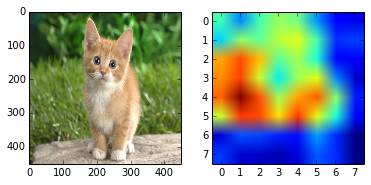

In [6]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# load input and configure preprocessing
im = caffe.io.load_image('images/cat.jpg')
transformer = caffe.io.Transformer({'data': net_full_conv.blobs['data'].data.shape})
transformer.set_mean('data', np.load('../python/caffe/imagenet/ilsvrc_2012_mean.npy').mean(1).mean(1))
transformer.set_transpose('data', (2,0,1))
transformer.set_channel_swap('data', (2,1,0))
transformer.set_raw_scale('data', 255.0)
# make classification map by forward and print prediction indices at each location
out = net_full_conv.forward_all(data=np.asarray([transformer.preprocess('data', im)]))
print out['prob'][0].argmax(axis=0)
# show net input and confidence map (probability of the top prediction at each location)
plt.subplot(1, 2, 1)
plt.imshow(transformer.deprocess('data', net_full_conv.blobs['data'].data[0]))
plt.subplot(1, 2, 2)
plt.imshow(out['prob'][0].max(axis=0))

The classifications include various cats -- 282 = tiger cat, 281 = tabby, 283 = persian -- and foxes and other mammals.

In this way the fully-connected layers can be extracted as dense features across an image (see `net_full_conv.blobs['fc6'].data` for instance), which is perhaps more useful than the classification map itself.

Note that this model isn't totally appropriate for sliding-window detection since it was trained for whole-image classification. Nevertheless it can work just fine. Sliding-window training and finetuning can be done by defining a sliding-window ground truth and loss such that a loss map is made for every location and solving as usual. (This is an exercise for the reader.)

*A thank you to Rowland Depp for first suggesting this trick.*